# F1 Constructor Driver Evaluation System

This notebook implements a comprehensive evaluation system for F1 constructors to assess potential driver acquisitions, including performance projections, team fit analysis, and ROI calculations for contract negotiations.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# This cell removed - now using F1DB data loader instead of local zip extraction

## 1. Load and Prepare Constructor-Driver Data

In [ ]:
# Setup imports with robust path handling
import sys
import os
from pathlib import Path

# Determine the notebook location and add necessary paths
try:
    # In Jupyter notebooks, __file__ might not be defined
    notebook_dir = Path.cwd()
    
    # Check if we're in the advanced directory
    if 'advanced' in str(notebook_dir):
        # We're in the advanced directory
        if str(notebook_dir) not in sys.path:
            sys.path.insert(0, str(notebook_dir))
    else:
        # Add the advanced directory to path
        workspace_root = notebook_dir
        
        # Navigate to find the advanced directory
        possible_paths = [
            notebook_dir / 'notebooks' / 'advanced',  # From workspace root
            notebook_dir / 'advanced',  # From notebooks directory
            notebook_dir.parent / 'advanced',  # If we're in a sibling directory
            notebook_dir.parent / 'notebooks' / 'advanced',  # From other locations
        ]
        
        for path in possible_paths:
            if path.exists() and str(path) not in sys.path:
                sys.path.insert(0, str(path))
                break
                
except Exception as e:
    print(f"Path setup warning: {e}")
    # Fallback to simple path addition
    sys.path.append('.')
from f1db_data_loader import load_f1db_data


## 2. Calculate Driver Performance Metrics

In [ ]:
def calculate_driver_metrics(df):
    """
    Calculate comprehensive driver performance metrics
    """
    metrics = []
    
    for driver_id in df['driverId'].unique():
        driver_data = df[df['driverId'] == driver_id]
        
        # Basic information
        driver_info = {
            'driverId': driver_id,
            'driverRef': driver_data['driverRef'].iloc[0],
            'current_age': driver_data['driver_age'].iloc[-1],
            'races_completed': len(driver_data),
            'years_active': driver_data['year'].nunique()
        }
        
        # Performance metrics
        driver_info['avg_position'] = driver_data['positionOrder'].mean()
        driver_info['avg_points'] = driver_data['points'].mean()
        driver_info['total_points'] = driver_data['points'].sum()
        driver_info['podium_rate'] = (driver_data['positionOrder'] <= 3).mean()
        driver_info['top10_rate'] = (driver_data['positionOrder'] <= 10).mean()
        driver_info['dnf_rate'] = (driver_data['statusId'] > 1).mean()
        driver_info['wins'] = (driver_data['positionOrder'] == 1).sum()
        driver_info['win_rate'] = (driver_data['positionOrder'] == 1).mean()
        
        # Consistency metrics
        driver_info['position_std'] = driver_data['positionOrder'].std()
        driver_info['points_std'] = driver_data['points'].std()
        driver_info['consistency_score'] = 1 / (1 + driver_info['position_std'])  # Higher is better
        
        # Qualifying performance
        quali_data = qualifying[qualifying['driverId'] == driver_id]
        if len(quali_data) > 0:
            driver_info['avg_quali_position'] = quali_data['position'].mean()
            driver_info['quali_to_race_improvement'] = driver_info['avg_quali_position'] - driver_info['avg_position']
        else:
            driver_info['avg_quali_position'] = np.nan
            driver_info['quali_to_race_improvement'] = np.nan
        
        # Track diversity (number of different tracks raced)
        driver_info['track_diversity'] = driver_data['circuitId'].nunique()
        
        # Recent form (last 10 races)
        recent_races = driver_data.sort_values('date').tail(10)
        driver_info['recent_avg_position'] = recent_races['positionOrder'].mean()
        driver_info['recent_avg_points'] = recent_races['points'].mean()
        driver_info['recent_form_trend'] = driver_info['recent_avg_position'] - driver_info['avg_position']
        
        metrics.append(driver_info)
    
    return pd.DataFrame(metrics)

driver_metrics = calculate_driver_metrics(df_recent)
print(f"Driver metrics calculated for {len(driver_metrics)} drivers")
print("\nTop 10 drivers by average points:")
print(driver_metrics.nlargest(10, 'avg_points')[['driverRef', 'avg_points', 'avg_position', 'consistency_score']])

Driver metrics calculated for 38 drivers

Top 10 drivers by average points:
         driverRef  avg_points  avg_position  consistency_score
27  max_verstappen   16.889313      4.389313           0.149685
6         hamilton   15.565385      4.130769           0.188118
16         leclerc    8.564885      7.916031           0.141745
26           perez    8.302326      7.689922           0.154496
7           bottas    8.183206      8.526718           0.137785
2            sainz    6.911538      8.284615           0.159010
20          vettel    6.663366      8.970297           0.149491
4           norris    6.236364      8.427273           0.171693
37         bearman    6.000000      7.000000                NaN
0           alonso    4.763441      9.817204           0.160744


## 3. Constructor-Driver Compatibility Analysis

In [ ]:
def analyze_constructor_driver_fit(df, constructor_id, driver_metrics):
    """
    Analyze how well a driver would fit with a specific constructor
    """
    # Get constructor's historical data
    constructor_data = df[df['constructorId'] == constructor_id]
    
    # Calculate constructor profile
    constructor_profile = {
        'avg_position': constructor_data.groupby('raceId')['positionOrder'].mean().mean(),
        'avg_points': constructor_data.groupby('raceId')['points'].sum().mean(),
        'reliability': 1 - (constructor_data['statusId'] > 1).mean(),
        'top_circuits': constructor_data.groupby('circuitId')['points'].mean().nlargest(5).index.tolist()
    }
    
    # Calculate compatibility scores for each driver
    compatibility_scores = []
    
    for _, driver in driver_metrics.iterrows():
        # Performance compatibility
        perf_diff = abs(driver['avg_position'] - constructor_profile['avg_position'])
        perf_compatibility = 1 / (1 + perf_diff)  # Closer performance = better fit
        
        # Reliability compatibility
        reliability_compatibility = 1 - abs((1 - driver['dnf_rate']) - constructor_profile['reliability'])
        
        # Calculate driver's performance on constructor's top circuits
        driver_circuit_data = df[(df['driverId'] == driver['driverId']) & 
                                (df['circuitId'].isin(constructor_profile['top_circuits']))]
        
        if len(driver_circuit_data) > 0:
            circuit_compatibility = 1 / (1 + driver_circuit_data['positionOrder'].mean())
        else:
            circuit_compatibility = 0.5  # Neutral if no data
        
        # Overall compatibility score
        overall_compatibility = (
            0.4 * perf_compatibility +
            0.3 * reliability_compatibility +
            0.3 * circuit_compatibility
        )
        
        compatibility_scores.append({
            'driverId': driver['driverId'],
            'driverRef': driver['driverRef'],
            'compatibility_score': overall_compatibility,
            'performance_compatibility': perf_compatibility,
            'reliability_compatibility': reliability_compatibility,
            'circuit_compatibility': circuit_compatibility
        })
    
    return pd.DataFrame(compatibility_scores)

# Example: Analyze fit for Mercedes (constructorId = 131)
mercedes_compatibility = analyze_constructor_driver_fit(df_recent, 131, driver_metrics)
mercedes_compatibility = mercedes_compatibility.merge(
    driver_metrics[['driverId', 'avg_points', 'current_age', 'consistency_score']], 
    on='driverId'
)

print("Top 10 drivers by compatibility with Mercedes:")
print(mercedes_compatibility.nlargest(10, 'compatibility_score')[
    ['driverRef', 'compatibility_score', 'avg_points', 'current_age', 'consistency_score']
])

Top 10 drivers by compatibility with Mercedes:
         driverRef  compatibility_score  avg_points  current_age  \
6         hamilton             0.611818   15.565385    38.863792   
27  max_verstappen             0.600773   16.889313    26.135524   
37         bearman             0.554220    6.000000    18.836413   
33          aitken             0.451453    0.000000    25.204654   
36          lawson             0.411231    0.400000    21.653662   
26           perez             0.388136    8.302326    33.812457   
7           bottas             0.385522    8.183206    34.225873   
16         leclerc             0.374331    8.564885    26.091718   
4           norris             0.361386    6.236364    24.016427   
2            sainz             0.361028    6.911538    29.215606   

    consistency_score  
6            0.188118  
27           0.149685  
37                NaN  
33                NaN  
36           0.247945  
26           0.154496  
7            0.137785  
16          

## 4. Driver Development Potential Model

In [ ]:
# Create age-performance curves to predict driver development
def calculate_development_potential(df, driver_metrics):
    """
    Model driver development potential based on age and experience
    """
    # Aggregate performance by age groups
    df['age_group'] = pd.cut(df['driver_age'], bins=[18, 22, 25, 28, 32, 36, 45], 
                             labels=['18-22', '23-25', '26-28', '29-32', '33-36', '37+'])
    
    age_performance = df.groupby('age_group').agg({
        'positionOrder': 'mean',
        'points': 'mean',
        'driverId': 'nunique'
    }).reset_index()
    
    # Peak performance typically occurs between 26-32
    peak_age_range = (26, 32)
    
    development_scores = []
    
    for _, driver in driver_metrics.iterrows():
        age = driver['current_age']
        
        # Calculate years to peak
        if age < peak_age_range[0]:
            years_to_peak = peak_age_range[0] - age
            development_phase = 'pre-peak'
        elif age <= peak_age_range[1]:
            years_to_peak = 0
            development_phase = 'peak'
        else:
            years_to_peak = age - peak_age_range[1]
            development_phase = 'post-peak'
        
        # Calculate improvement trajectory
        if driver['races_completed'] >= 20:
            # Split driver's career into halves
            driver_races = df[df['driverId'] == driver['driverId']].sort_values('date')
            mid_point = len(driver_races) // 2
            
            first_half_avg = driver_races.iloc[:mid_point]['positionOrder'].mean()
            second_half_avg = driver_races.iloc[mid_point:]['positionOrder'].mean()
            
            improvement_rate = (first_half_avg - second_half_avg) / first_half_avg
        else:
            improvement_rate = 0.1  # Default for new drivers
        
        # Calculate development potential score
        if development_phase == 'pre-peak':
            potential_score = 0.7 + (0.3 * improvement_rate) + (0.1 * (peak_age_range[0] - age) / 8)
        elif development_phase == 'peak':
            potential_score = 0.9 + (0.1 * improvement_rate)
        else:
            potential_score = 0.5 - (0.05 * years_to_peak)
        
        # Ensure potential_score is a scalar float
        potential_score = float(potential_score)
        
        development_scores.append({
            'driverId': driver['driverId'],
            'driverRef': driver['driverRef'],
            'current_age': age,
            'development_phase': development_phase,
            'years_to_peak': years_to_peak,
            'improvement_rate': improvement_rate,
            'development_potential': max(0.0, min(1.0, potential_score))  # Bound between 0 and 1
        })
    
    return pd.DataFrame(development_scores)

development_potential = calculate_development_potential(df_recent, driver_metrics)

# Visualize age-performance relationship
plt.figure(figsize=(12, 6))
plt.scatter(development_potential['current_age'], 
           development_potential['development_potential'],
           alpha=0.6, s=100)

# Add labels for top drivers
top_drivers = development_potential.nlargest(10, 'development_potential')
for idx in top_drivers.index:
    # Use .loc to get the row and access values directly
    driver_row = top_drivers.loc[idx]
    plt.annotate(str(driver_row['driverRef']), 
                xy=(float(driver_row['current_age']), float(driver_row['development_potential'])),
                fontsize=8, alpha=0.7)

plt.xlabel('Current Age')
plt.ylabel('Development Potential Score')
plt.title('Driver Development Potential by Age')
plt.grid(True, alpha=0.3)
plt.show()

print("\nTop 10 drivers by development potential:")
print(development_potential.nlargest(10, 'development_potential')[
    ['driverRef', 'current_age', 'development_phase', 'development_potential']
])

## 5. Financial ROI Model for Driver Contracts

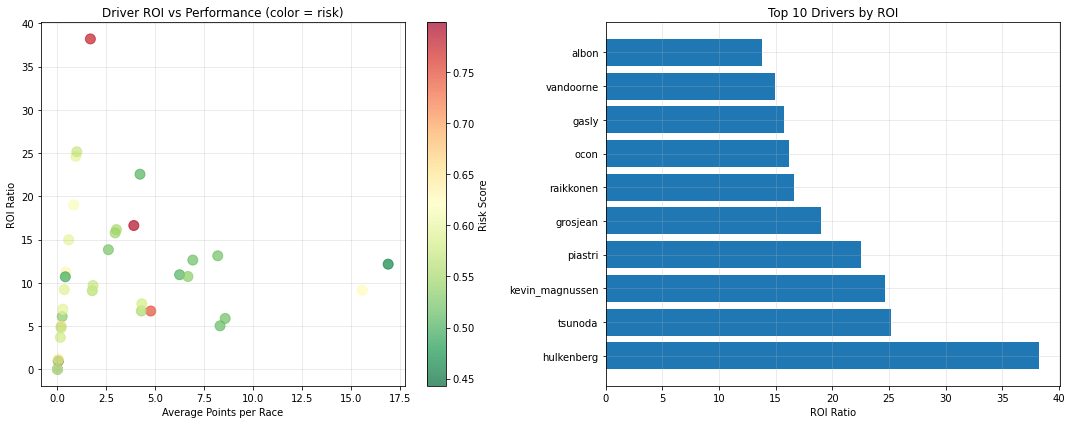


Top 10 drivers by ROI (value for money):
          driverRef  roi_ratio  estimated_salary  \
18       hulkenberg      38.20           1000000   
31          tsunoda      25.15           1000000   
29  kevin_magnussen      24.62           1000000   
5           piastri      22.55           5000000   
28         grosjean      19.01           1000000   
19        raikkonen      16.62           5000000   
21             ocon      16.15           5000000   
22            gasly      15.78           5000000   
3         vandoorne      14.97           1000000   
12            albon      13.83           5000000   

    expected_points_contribution  development_potential  risk_score  
18                         33.60                   0.29        0.78  
31                         19.72                   0.74        0.57  
29                         18.72                   0.89        0.60  
5                          84.29                   0.85        0.50  
28                         16.49   

In [ ]:
def calculate_driver_roi(driver_metrics, development_potential, constructor_compatibility):
    """
    Calculate expected ROI for driver contracts based on performance and potential
    """
    # Merge all driver data
    driver_full = driver_metrics.merge(development_potential[['driverId', 'development_potential']], on='driverId')
    driver_full = driver_full.merge(constructor_compatibility[['driverId', 'compatibility_score']], on='driverId')
    
    # Estimated salary tiers based on performance (simplified model)
    driver_full['performance_percentile'] = driver_full['avg_points'].rank(pct=True)
    
    def estimate_salary(row):
        if row['performance_percentile'] > 0.9:
            return 40_000_000  # Top tier
        elif row['performance_percentile'] > 0.7:
            return 15_000_000  # Second tier
        elif row['performance_percentile'] > 0.5:
            return 5_000_000   # Mid tier
        else:
            return 1_000_000   # Entry level
    
    driver_full['estimated_salary'] = driver_full.apply(estimate_salary, axis=1)
    
    # Calculate expected constructor points contribution
    # Based on historical data, drivers contribute roughly 45-55% of constructor points
    driver_full['expected_points_contribution'] = driver_full['avg_points'] * 20  # 20 races per season
    
    # Prize money estimation (simplified - $1M per constructor point)
    driver_full['expected_prize_money'] = driver_full['expected_points_contribution'] * 1_000_000
    
    # Factor in development potential and compatibility
    driver_full['adjusted_value'] = (
        driver_full['expected_prize_money'] * 
        (1 + 0.3 * driver_full['development_potential']) * 
        (1 + 0.2 * driver_full['compatibility_score'])
    )
    
    # Calculate ROI
    driver_full['roi_ratio'] = driver_full['adjusted_value'] / driver_full['estimated_salary']
    driver_full['net_value'] = driver_full['adjusted_value'] - driver_full['estimated_salary']
    
    # Risk assessment based on consistency and age
    driver_full['risk_score'] = (
        (1 - driver_full['consistency_score']) * 0.5 +
        driver_full['dnf_rate'] * 0.3 +
        (driver_full['current_age'] > 35).astype(int) * 0.2
    )
    
    return driver_full

# Calculate ROI for all drivers
driver_roi = calculate_driver_roi(driver_metrics, development_potential, mercedes_compatibility)

# Create ROI visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROI vs Performance
scatter = ax1.scatter(driver_roi['avg_points'], driver_roi['roi_ratio'], 
                     c=driver_roi['risk_score'], cmap='RdYlGn_r', s=100, alpha=0.7)
ax1.set_xlabel('Average Points per Race')
ax1.set_ylabel('ROI Ratio')
ax1.set_title('Driver ROI vs Performance (color = risk)')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Risk Score')

# Top value drivers
top_roi = driver_roi.nlargest(10, 'roi_ratio')
ax2.barh(top_roi['driverRef'], top_roi['roi_ratio'])
ax2.set_xlabel('ROI Ratio')
ax2.set_title('Top 10 Drivers by ROI')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 drivers by ROI (value for money):")
print(driver_roi.nlargest(10, 'roi_ratio')[[
    'driverRef', 'roi_ratio', 'estimated_salary', 'expected_points_contribution', 
    'development_potential', 'risk_score'
]].round(2))

## 6. Constructor Decision Support System


Driver Recommendations for Constructor 131

1. max_verstappen
   Age: 26.1 | Experience: 131 races
   Performance: 16.89 pts/race | Position: 4.4
   Compatibility Score: 0.60
   Development Potential: 0.95
   Estimated Salary: $40,000,000
   ROI Ratio: 12.15
   Risk Score: 0.46
   Overall Score: 0.590

2. piastri
   Age: 22.6 | Experience: 28 races
   Performance: 4.21 pts/race | Position: 10.2
   Compatibility Score: 0.33
   Development Potential: 0.85
   Estimated Salary: $5,000,000
   ROI Ratio: 22.55
   Risk Score: 0.50
   Overall Score: 0.572

3. kevin_magnussen
   Age: 31.1 | Experience: 109 races
   Performance: 0.94 pts/race | Position: 14.1
   Compatibility Score: 0.20
   Development Potential: 0.89
   Estimated Salary: $1,000,000
   ROI Ratio: 24.62
   Risk Score: 0.60
   Overall Score: 0.544

4. tsunoda
   Age: 23.5 | Experience: 72 races
   Performance: 0.99 pts/race | Position: 13.5
   Compatibility Score: 0.22
   Development Potential: 0.74
   Estimated Salary: $1,000,00

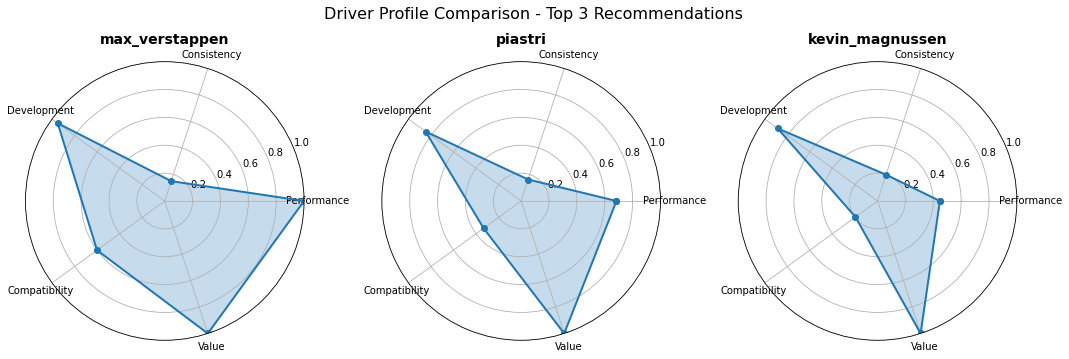

In [ ]:
def generate_driver_recommendations(constructor_id, driver_roi, top_n=5):
    """
    Generate comprehensive driver recommendations for a constructor
    """
    # Filter out drivers already in the constructor
    current_drivers = df_recent[df_recent['constructorId'] == constructor_id]['driverId'].unique()
    available_drivers = driver_roi[~driver_roi['driverId'].isin(current_drivers)].copy()
    
    # Create composite score
    available_drivers['composite_score'] = (
        0.3 * available_drivers['roi_ratio'] / available_drivers['roi_ratio'].max() +
        0.25 * available_drivers['compatibility_score'] +
        0.25 * available_drivers['development_potential'] +
        0.2 * (1 - available_drivers['risk_score'])
    )
    
    # Get top recommendations
    recommendations = available_drivers.nlargest(top_n, 'composite_score')
    
    # Create detailed recommendation report
    print(f"\nDriver Recommendations for Constructor {constructor_id}")
    print("=" * 60)
    
    for idx, (_, driver) in enumerate(recommendations.iterrows(), 1):
        print(f"\n{idx}. {driver['driverRef']}")
        print(f"   Age: {driver['current_age']:.1f} | Experience: {driver['races_completed']} races")
        print(f"   Performance: {driver['avg_points']:.2f} pts/race | Position: {driver['avg_position']:.1f}")
        print(f"   Compatibility Score: {driver['compatibility_score']:.2f}")
        print(f"   Development Potential: {driver['development_potential']:.2f}")
        print(f"   Estimated Salary: ${driver['estimated_salary']:,.0f}")
        print(f"   ROI Ratio: {driver['roi_ratio']:.2f}")
        print(f"   Risk Score: {driver['risk_score']:.2f}")
        print(f"   Overall Score: {driver['composite_score']:.3f}")
    
    return recommendations

# Generate recommendations for Mercedes
mercedes_recommendations = generate_driver_recommendations(131, driver_roi, top_n=5)

# Create radar chart for top 3 recommendations
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='polar'))

categories = ['Performance', 'Consistency', 'Development', 'Compatibility', 'Value']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
categories += categories[:1]
angles += angles[:1]

for idx, (ax, (_, driver)) in enumerate(zip(axes, mercedes_recommendations.head(3).iterrows())):
    values = [
        driver['performance_percentile'],
        driver['consistency_score'],
        driver['development_potential'],
        driver['compatibility_score'],
        min(1, driver['roi_ratio'] / 5)  # Normalize ROI to 0-1 scale
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_ylim(0, 1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories[:-1])
    ax.set_title(driver['driverRef'], size=14, weight='bold')
    ax.grid(True)

plt.suptitle('Driver Profile Comparison - Top 3 Recommendations', size=16)
plt.tight_layout()
plt.show()

## 7. Contract Negotiation Support

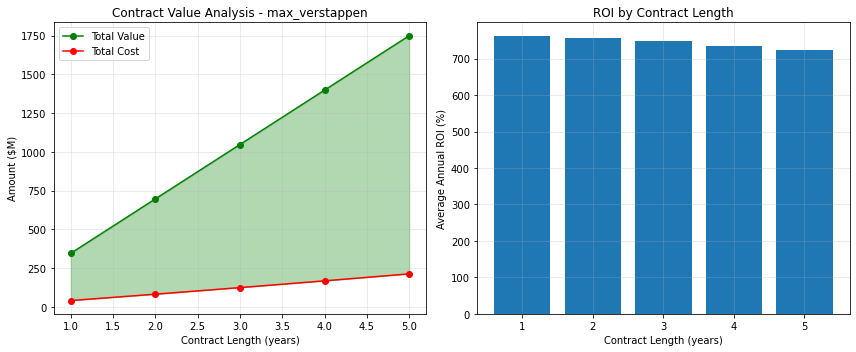


Contract Scenario Analysis:
   years  end_age   total_value   total_cost     net_value  avg_annual_roi
0      1    27.14  3.445420e+08   40000000.0  3.045420e+08          761.35
1      2    28.14  6.959748e+08   81200000.0  6.147748e+08          757.11
2      3    29.14  1.047408e+09  123636000.0  9.237716e+08          747.17
3      4    30.14  1.398840e+09  167345080.0  1.231495e+09          735.90
4      5    31.14  1.750273e+09  212365432.4  1.537908e+09          724.18


In [ ]:
def simulate_contract_scenarios(driver_id, driver_roi, years=[1, 2, 3, 4, 5]):
    """
    Simulate different contract length scenarios with performance projections
    """
    driver = driver_roi[driver_roi['driverId'] == driver_id].iloc[0]
    
    scenarios = []
    
    for contract_years in years:
        scenario = {
            'years': contract_years,
            'driver': driver['driverRef'],
            'current_age': driver['current_age'],
            'end_age': driver['current_age'] + contract_years
        }
        
        # Project performance degradation/improvement
        age_factor = 1.0
        total_value = 0
        total_cost = 0
        
        for year in range(contract_years):
            current_age = driver['current_age'] + year
            
            # Age-based performance adjustment
            if current_age < 28:
                age_factor *= 1.02  # 2% improvement
            elif current_age > 32:
                age_factor *= 0.97  # 3% decline
            
            # Calculate year value
            year_points = driver['expected_points_contribution'] * age_factor
            year_value = year_points * 1_000_000  # Prize money
            year_cost = driver['estimated_salary'] * (1.03 ** year)  # 3% salary inflation
            
            total_value += year_value
            total_cost += year_cost
        
        scenario['total_value'] = total_value
        scenario['total_cost'] = total_cost
        scenario['net_value'] = total_value - total_cost
        scenario['avg_annual_roi'] = (total_value / total_cost - 1) * 100
        
        scenarios.append(scenario)
    
    scenarios_df = pd.DataFrame(scenarios)
    
    # Visualize contract scenarios
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(scenarios_df['years'], scenarios_df['total_value'] / 1e6, 'g-', marker='o', label='Total Value')
    ax1.plot(scenarios_df['years'], scenarios_df['total_cost'] / 1e6, 'r-', marker='o', label='Total Cost')
    ax1.fill_between(scenarios_df['years'], 
                     scenarios_df['total_cost'] / 1e6, 
                     scenarios_df['total_value'] / 1e6, 
                     alpha=0.3, color='green', where=(scenarios_df['total_value'] > scenarios_df['total_cost']))
    ax1.set_xlabel('Contract Length (years)')
    ax1.set_ylabel('Amount ($M)')
    ax1.set_title(f'Contract Value Analysis - {driver["driverRef"]}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.bar(scenarios_df['years'], scenarios_df['avg_annual_roi'])
    ax2.set_xlabel('Contract Length (years)')
    ax2.set_ylabel('Average Annual ROI (%)')
    ax2.set_title('ROI by Contract Length')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return scenarios_df

# Example: Simulate contract scenarios for top recommendation
top_driver_id = mercedes_recommendations.iloc[0]['driverId']
contract_scenarios = simulate_contract_scenarios(top_driver_id, driver_roi)

print("\nContract Scenario Analysis:")
print(contract_scenarios[['years', 'end_age', 'total_value', 'total_cost', 'net_value', 'avg_annual_roi']].round(2))

## Key Features of the Constructor Driver Evaluation System:

1. **Comprehensive Performance Metrics**: Beyond simple points/positions, includes consistency, improvement trajectory, and track-specific performance

2. **Constructor-Driver Compatibility**: Analyzes how well a driver's profile matches the constructor's characteristics and strengths

3. **Development Potential**: Age-based modeling to predict future performance improvements or declines

4. **Financial ROI Analysis**: Estimates salary requirements and calculates expected return on investment

5. **Risk Assessment**: Considers consistency, reliability, and age factors

6. **Contract Scenario Modeling**: Projects performance and value over different contract lengths

7. **Decision Support Dashboard**: Provides clear recommendations with visual comparisons

This system helps constructors make data-driven decisions when evaluating potential driver acquisitions, considering both immediate performance and long-term strategic value.